# Random Forest Final Model

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [3]:
site = config.site
site_name = config.site_dict[site]
assert site == 'GSN', 'This script is only for Gosan, South Korea.'

compound = config.compound

print(f"Creating a random forest model for \033[1m{site_name}\033[0;0m.")

Creating a random forest model for Gosan, South Korea.


### Loading & Initialising Data

In [4]:
data = pd.read_csv(data_path/f'for_model_pca_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,flag
9380,2016-07-08 17:00:00,10.125860,-3.105480,2.753387,0.338740,1.982636,2.806766,-1.784353,2.876619,1.680387,...,1.827028,2.083966,2.635722,-0.038497,-1.707998,0.887971,-0.695556,-0.084464,-0.050416,0.0
7043,2013-11-28 19:00:00,-7.592790,4.642798,1.636641,-5.025380,4.809820,0.505511,-3.207865,-0.225591,0.245325,...,-1.887251,1.060726,-2.042437,-0.385945,1.402942,0.664568,0.819315,-0.543561,-0.990304,1.0
9283,2016-04-18 13:00:00,-0.889724,4.645906,-0.060927,0.224448,0.538654,-0.645266,-2.466586,4.664384,-0.531360,...,1.043065,-1.029275,1.780407,1.653178,-1.116741,-0.500994,3.770398,-0.545271,-0.097949,1.0
5003,2011-12-17 03:00:00,-6.672218,-0.750634,-1.029859,0.670512,2.380378,-0.171419,-0.237350,-0.350088,-0.418840,...,0.493256,1.889892,-2.419431,0.910049,1.695579,-0.715413,-0.395906,-0.439826,1.315512,1.0
6743,2013-08-16 19:00:00,10.755849,-1.351726,-3.273224,-1.630861,1.720608,1.557657,0.071176,2.328395,-0.148697,...,-1.038361,-0.508888,-2.870782,-0.194511,-0.645367,0.111486,1.874873,0.502733,0.816860,0.0


In [5]:
train_data = data[(data['time'].dt.year >= 2011) & (data['time'].dt.year <= 2013)]
val_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2014)]
test_data = data[(data['time'].dt.year >= 2015) & (data['time'].dt.year <= 2017)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2011-01-01 11:00:00 -> 2013-12-30 09:00:00. Length: 3186
Val range: 2014-01-03 19:00:00 -> 2014-12-31 23:00:00. Length: 933
Test range: 2015-01-01 01:00:00 -> 2017-12-31 23:00:00. Length: 2824


### Model

In [9]:
# fitting models based on optimal hyperparameters

rf_model = RandomForestClassifier(random_state=42,
                                  n_estimators=200,
                                  max_depth=5,
                                  criterion='entropy',
                                  bootstrap=True,
                                  max_features=None,)

rf_model.fit(X_train, y_train)

class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = config.confidence_threshold

y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.976
Precision on Validation Set = 0.923
Recall on Training Set = 0.814
Recall on Validation Set = 0.596
F1 Score on Training Set = 0.888
F1 Score on Validation Set = 0.724


C:\Users\kirst\AppData\Local\Temp\ipykernel_11380\3156113180.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_importances.index)


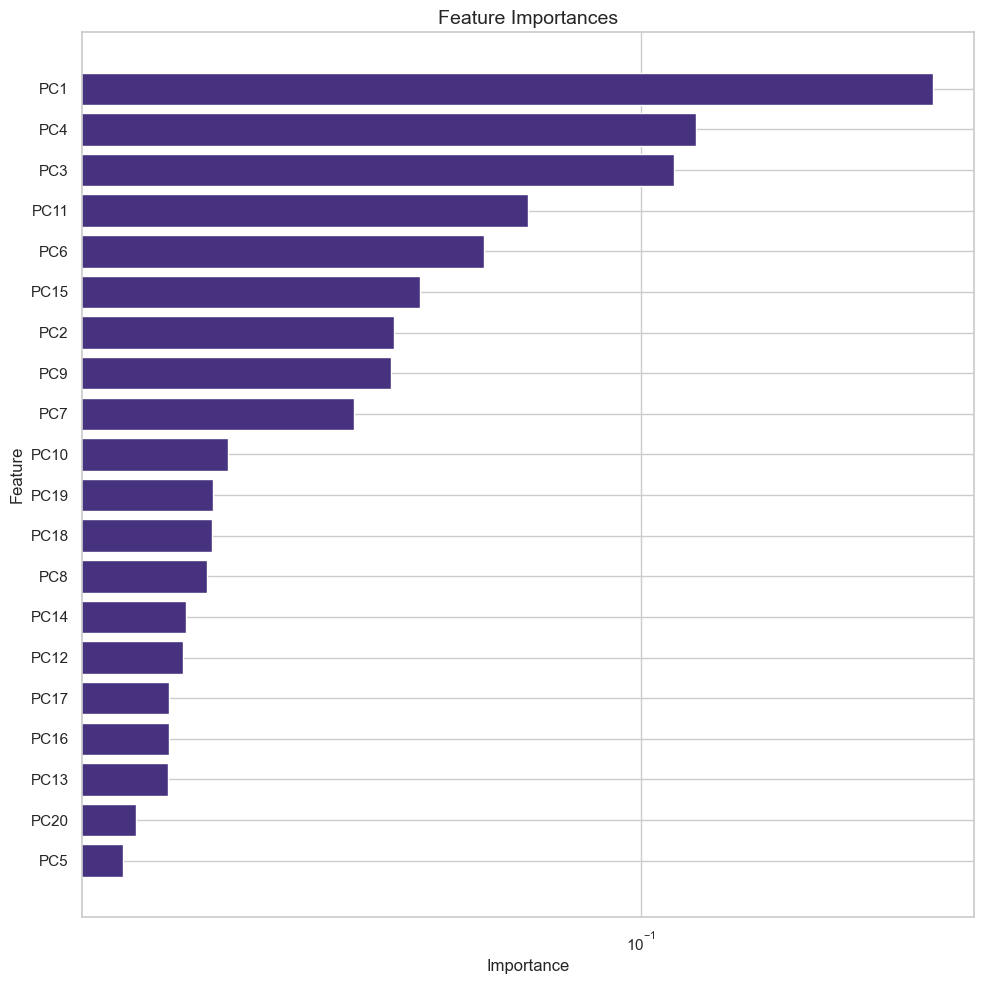

In [10]:
# finding most important features in the model

feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style='whitegrid')
sns.set_palette("viridis")

# sorting feature importances
feature_importances = feature_importances.sort_values('importance', ascending=True)

# bar chart of feature importances
ax.barh(feature_importances.index, feature_importances['importance'])

# making y axis logaritmic
ax.set_xscale('log')

ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances', fontsize=14)
ax.set_yticklabels(feature_importances.index)

fig.tight_layout()

In [11]:
# evaluating the model on the test set

class_probabilities_test = rf_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_test:.3f}")

Precision on Test Set = 0.921
Recall on Test Set = 0.722
F1 Score on Test Set = 0.809


In [12]:
# saving model
dump(rf_model, data_path/f'rf_model_GSN.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\rf_model_GSN.joblib']